<a href="https://colab.research.google.com/github/rixwan-khan/Credit_Card_Fraud_Detection/blob/main/credit_card_fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> # **Credit Card Fraud Detection**

In this project, we focus on building a Credit Card Fraud Detection system using historical transaction data. The dataset labels each transaction as either:

Fraudulent (1) – Transactions identified as fraud.\
Normal (0) – Legitimate transactions.

\
**Objective:**
Develop a model that can accurately identify fraudulent transactions while minimizing false negatives, thereby enabling timely and reliable fraud detection.


### **0. Importing Libraries**

In [2]:
# Data Handling Libraries
import numpy as np
import pandas as pd
from datetime import datetime

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools

# Machine Learning & Modeling
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn import svm

# Gradient boosting & Advance models
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb
from catboost import CatBoostClassifier

In [3]:
!pip install catboost

##**1. Loading Dataset from Kaggle**

In [4]:
!pip install kaggle

# Upload kaggle.json from your Kaggle account
from google.colab import files
files.upload()   # upload kaggle.json

# Setup credentials
import os
os.makedirs("/root/.kaggle", exist_ok=True)
!mv kaggle.json /root/.kaggle/
os.chmod("/root/.kaggle/kaggle.json", 600)

# Download dataset
!kaggle datasets download -d mlg-ulb/creditcardfraud

# Unzip dataset
!unzip creditcardfraud.zip

# Load into pandas
import pandas as pd
df = pd.read_csv("creditcard.csv")



Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
License(s): DbCL-1.0
creditcardfraud.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  creditcardfraud.zip
replace creditcard.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: creditcard.csv          y



In [5]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## **2. Data Exploration (EDA)**

In this section, exploring the dataset to understand its structure, and class imbalance. Visualizations and summary statistics will help identify patterns, outliers, and insights for building an effective fraud detection model.

###**2.1 Dataset Structure & Summary**

In [6]:
df.shape

(284807, 31)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

The dataset contains 284,807 transactions with 31 columns, including anonymized features, transaction amount, time, and a target class indicating fraud (1) or genuine (0).

### **2.2 Statistical Summary**

In [8]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


The transaction amounts range from \$0 to \$25,691, with most transactions below \$100 (median \$22).

### **2.3 Missing Values**

In [9]:
df.isna().sum()

,0
Time,0
V1,0
V2,0
V3,0
V4,0
V5,0
V6,0
V7,0
V8,0
V9,0


### **2.4 Checking Duplicate:**

In [10]:
dup = df.duplicated().sum()
print('Duplicated rows:',dup)

Duplicated rows: 1081


#### ***2.4.1 Removing Duplicate Rows:***

In [11]:
df_copy = df.copy()
df = df.drop_duplicates()

### **2.5 Class Distribution (%)**

In [12]:
dist = df['Class'].value_counts(normalize=True)*100
dist

,proportion
Class,
0,99.83329
1,0.16671


#### **2.5.1 Transaction Amount based on Class**

In [13]:
# Transaction class:  0=Normal, 1=Fraud

non_fraud_txn = df[df['Class']==0]
fraud_txn = df[df['Class']==1]

In [14]:
# statistical summary for the Amount column of non-fraudulent transactions
non_fraud_txn.Amount.describe()

,Amount
count,283253.000000
mean,88.413575
std,250.379023
min,0.000000
25%,5.670000
50%,22.000000
75%,77.460000
max,25691.160000


In [15]:
# statistical summary for the Amount column of fraudulent transactions
fraud_txn.Amount.describe()

,Amount
count,473.000000
mean,123.871860
std,260.211041
min,0.000000
25%,1.000000
50%,9.820000
75%,105.890000
max,2125.870000


The dataset is highly imbalanced, with only a tiny fraction (0.17%) of transactions labeled as fraudulent and 99.8% are Normal.

By checking missing values it shows that there is no missing values in dataset.

## **3. Visualization**

### **3.1 Class Distribution**

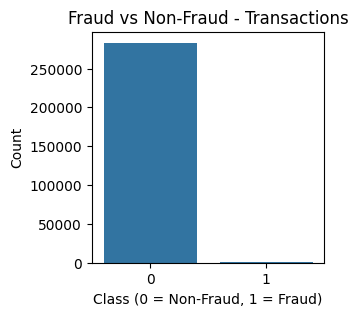

In [16]:
plt.figure(figsize=(3,3))

sns.countplot(x='Class', data=df)
plt.title('Fraud vs Non-Fraud - Transactions')
plt.xlabel('Class (0 = Non-Fraud, 1 = Fraud)')
plt.ylabel('Count')
plt.show();

Most transactions in the dataset are non-fraud, and only a few are fraudulent. This means normal models might find it hard to detect fraud, so we may need methods like oversampling, undersampling, or anomaly detection. The bar chart clearly shows this imbalance.

### **3.2 Outlier detection**

#### **3.2.1 Transaction amount comparision**

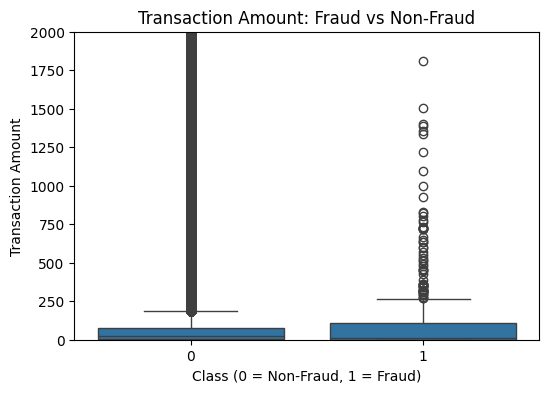

In [17]:
plt.figure(figsize=(6,4))

sns.boxplot(
    x = 'Class',
    y = 'Amount',
    data = df
)
plt.title('Transaction Amount: Fraud vs Non-Fraud')
plt.xlabel('Class (0 = Non-Fraud, 1 = Fraud)')
plt.ylabel('Transaction Amount')
plt.ylim(0, 2000)
plt.show()

- In Class 0 (non-fraud), most transactions are of small amounts, with a few reaching up to 2000, which are considered normal.

- In Class 1 (fraud), while many transactions are small, there are several extremely high-value transactions shown as circles, indicating outliers. This suggests that high transaction amounts can be useful for detecting fraud.

#### **3.2.2 Interquartile Range (IQR)**

In [18]:

# For Class 0 = Non-Fraud
non_fraud = df[df['Class'] == 0]['Amount']
Q1_0 = non_fraud.quantile(0.25) # 25th percentile
Q3_0 = non_fraud.quantile(0.75) # 75th percentile
IQR_0 = Q3_0 - Q1_0    # IQR range

# For Class 1 - Fraud
fraud = df[df['Class'] == 1]['Amount']
Q1_1 = fraud.quantile(0.25)    # 25th percentile
Q3_1 = fraud.quantile(0.75)    # 75th percentile
IQR_1 = Q3_1 - Q1_1            # IQR range

print("Fraud -  IQR - value:", IQR_1)
print("Non_Fraud - IQR value:", IQR_0)

Fraud -  IQR - value: 104.89
Non_Fraud - IQR value: 71.78999999999999


- IQR for non-fraud transactions (Class 0) is 71.79, indicating that most transactions are small and closely grouped.

- IQR for fraud transactions (Class 1), the IQR is 104.89, showing greater variation in amounts, with some transactions being much higher, which can help in detecting fraud."

### **3.3 Transaction based on time**

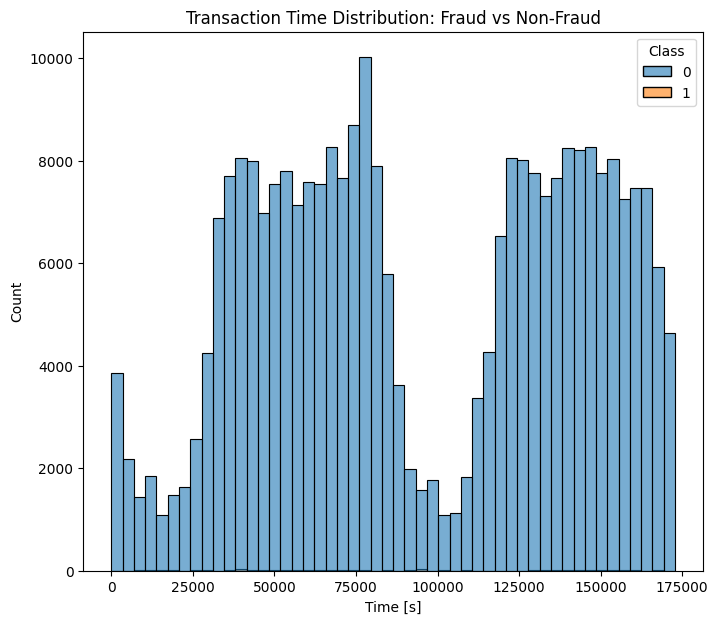

In [25]:
non_fraud_txn = df[df['Class'] == 0]['Time']
fraud_txn = df[df['Class'] == 1]['Time']

# Create DataFrame with a 'Class' column
df_non_fraud = pd.DataFrame({
    'Time': non_fraud_txn,
    'Class': 0
})

df_fraud = pd.DataFrame({
    'Time': fraud_txn,
    'Class': 1
})

# Combine both DataFrames
df_hist = pd.concat([df_non_fraud, df_fraud], ignore_index=True)

# Plot
plt.figure(figsize=(8,7))
sns.histplot(
    data=df_hist,
    x='Time',
    hue='Class',
    bins=50,
    alpha=0.6,
    kde=False
)

plt.title('Transaction Time Distribution: Fraud vs Non-Fraud')
plt.xlabel('Time [s]')
plt.ylabel('Count')
plt.show()

In [24]:
non_fraud_txn = df[df['Class'] == 0]['Time']
fraud_txn = df[df['Class'] == 1]['Time']

# combining both above dataset for plotting
hist_data = [fraud_txn, non_fraud_txn]

df_hist = pd.DataFrame(hist_data, columns=['Time'])

plt.figure(figsize=(8,7))
sns.histplot(
    data= df_hist,
    x = 'Time',
    hue = 'Amount',
    bins = 50,
    alpha = 0.6,
    kde = False
)

plt.title('Transaction Time Distribution: Fraud vs Non-Fraud')
plt.xlabel('Time [s]')
plt.ylabel('Count')
plt.show();

ValueError: Could not interpret value `Amount` for `hue`. An entry with this name does not appear in `data`.

<Figure size 800x700 with 0 Axes>

### **3.1 Correlation Analysis**

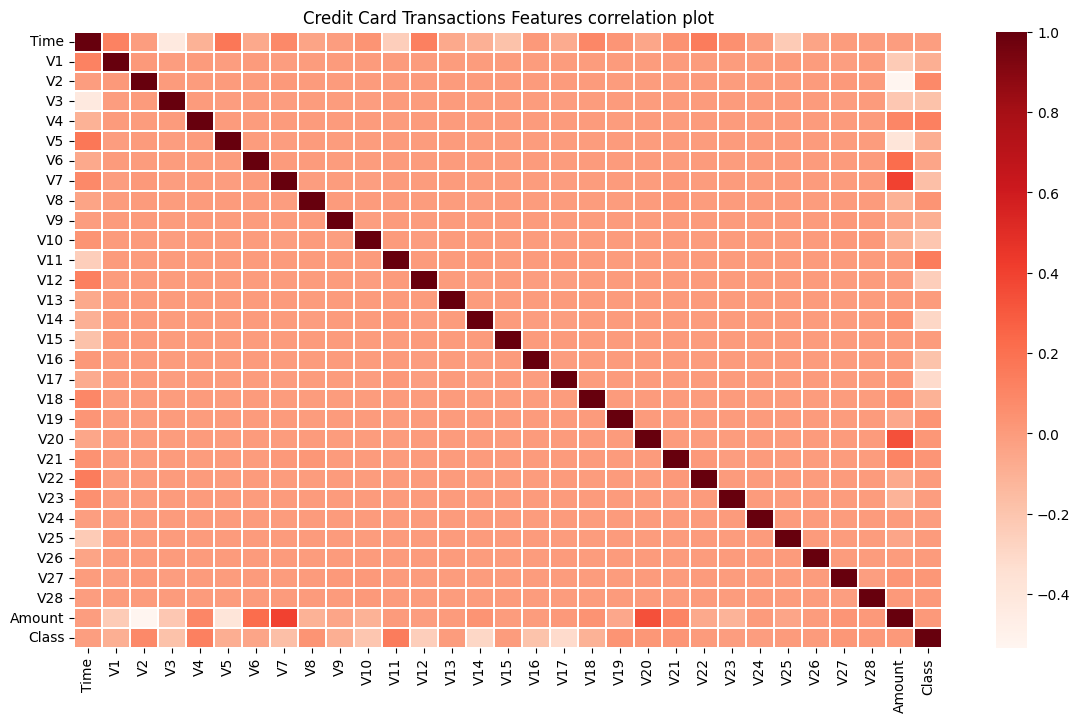

In [20]:
plt.figure(figsize=(14,8))
plt.title('Credit Card Transactions Features correlation plot')
corr = df.corr()
sns.heatmap(
    corr,
    xticklabels=corr.columns,
    yticklabels=corr.columns,
    linewidths=.1,
    cmap='Reds'
)

plt.show();

**Amount vs. Class:** The correlation between the transaction amount and fraud (Class) is very weak (close to 0). This means the size of a transaction alone does not strongly indicate whether it is fraudulent.

**Time vs. Class:** The correlation between the transaction time and fraud is also very weak. This suggests that fraudulent transactions can occur at any time and are not concentrated at specific times in the dataset.

### **3.2 Comparing Transaction Times: Fraud vs Not Fraud**

In [21]:
# Transaction selection based on the time
# Fraud = 1,  Non-Fraud = 0
non_fraud_txn = df[df['Class'] == 0]['Time']
fraud_txn = df[df['Class'] == 1]['Time']

# combining both above dataset for plotting
hist_data = [fraud_txn, non_fraud_txn]

# labels for plot legend.
group_labels = ['Not Fraud', 'Fraud']

# By using ploty figure create desity curve
fig  = ff.create_distplot(
    hist_data,        # transactions list (fraud, non_fraud)
    group_labels,     # legned's label
    show_hist = False,# To disable histogram in plot
    show_rug=False    # remove rug mark for each data point.
)

# layout of the figure
fig['layout'].update(
    title='Fraud vs Non-Fraud transation comparision over time',
    xaxis=dict(title='Time[s]'), # time in seconds
    width=900,    # Width of the plot in pixels
    height=700    # height of the plot in pixels
    )
fig.show()

>Fraudulent transactions are more evenly distributed over time compared to legitimate transactions. They occur consistently, including during periods of low activity, such as nighttime in the European timezone. This suggests fraud can happen even when normal transaction volume is minimal, highlighting higher relative risk during off-peak hours.